# Recurrent Neural Network

##Mounting Google drive space

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

DATA_PATH = 'gdrive/My Drive/ADBI CAPSTONE PROJECT DELIVERABLES/Dataset/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import required libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras import layers, regularizers, optimizers
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Activation, Input, Reshape
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer
import re

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

plt.switch_backend('agg')
%matplotlib inline

Using TensorFlow backend.


In [0]:
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed, CuDNNLSTM
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline

## Initialization of variables

In [0]:
MAX_SENT_LENGTH = 100
MAX_SENTS = 15
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.2
MAX_SEQUENCE_LENGTH = 1000

## Importing dataset

In [0]:
# Setting Data Path to dataset folder
DATA_PATH = 'gdrive/My Drive/Capstone Deliverables/Dataset/'

# Setting the data to the contents of the dataset
data = DATA_PATH + 'yelp.csv'

# Reading data file contents to sample using pandas library
sample = pd.read_csv(data)

# Cleaning data - dropping NA values
sample = sample.dropna()

# Resetting index position
sample = sample.reset_index(drop=True)
print('Shape of dataset ',sample.shape)
print(sample.columns)
print('No. of unique classes',len(set(sample['stars'])))

Shape of dataset  (10000, 10)
Index(['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id',
       'cool', 'useful', 'funny'],
      dtype='object')
No. of unique classes 5


## Details about the dataset

In [0]:
print('Shape of dataset :',sample.shape)
print('Data columns :', sample.columns)
print('No. of unique types :',len(set(sample.type)))
print('No. of unique stars :',len(set(sample.stars)))
print('No. of unique texts :',len(set(sample.text)))
print('Data for top 5 rows :', sample.head())
sample.describe(include='all')

Shape of dataset : (10000, 10)
Data columns : Index(['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id',
       'cool', 'useful', 'funny'],
      dtype='object')
No. of unique types : 1
No. of unique stars : 5
No. of unique texts : 9998
Data for top 5 rows :               business_id        date               review_id  stars  \
0  9yKzy9PApeiPPOUJEtnvkg  2011-01-26  fWKvX83p0-ka4JS3dc6E5A      5   
1  ZRJwVLyzEJq1VAihDhYiow  2011-07-27  IjZ33sJrzXqU-0X6U8NwyA      5   
2  6oRAC4uyJCsJl1X0WZpVSA  2012-06-14  IESLBzqUCLdSzSqm0eCSxQ      4   
3  _1QQZuf4zZOyFCvXc0o6Vg  2010-05-27  G-WvGaISbqqaMHlNnByodA      5   
4  6ozycU1RpktNG2-1BroVtw  2012-01-05  1uJFq2r5QfJG_6ExMRCaGw      5   

                                                text    type  \
0  My wife took me here on my birthday for breakf...  review   
1  I have no idea why some people give bad review...  review   
2  love the gyro plate. Rice is so good and I als...  review   
3  Rosie, Dakota, and I LOVE Cha

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
count,10000,10000,10000,10000.000000,10000,10000,10000,10000.000000,10000.000000,10000.000000
unique,4174,1995,10000,NaN,9998,1,6403,NaN,NaN,NaN
top,ntN85eu27C04nwyPa8IHtw,2011-03-28,oNwDrHblUgBYY8KcB9FiJg,NaN,This review is for the chain in general. The l...,review,fczQCSmaWF78toLEmb0Zsw,NaN,NaN,NaN
freq,37,21,1,NaN,2,10000,38,NaN,NaN,NaN
mean,NaN,NaN,NaN,3.777500,NaN,NaN,NaN,0.876800,1.409300,0.701300
std,NaN,NaN,NaN,1.214636,NaN,NaN,NaN,2.067861,2.336647,1.907942
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,0.000000,1.000000,0.000000
75%,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,1.000000,2.000000,1.000000


## Downloading stopwords

In [0]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
exclusion_list = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]

for word in exclusion_list:
    stop_words.remove(word)

## Define a cleanup function

In [0]:
def clean(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    
    # Remove anything else and just keep the alphabets    
    review = re.sub('[^a-zA-Z]', ' ', string)
        
    # Convert the review to lovercase
    review = review.lower()
    
    # Split the reviews into words
    review_words = review.split()
    
    # Remove any stop words
    cleaned_words = [word for word in review_words if not word in stop_words]   
        
    # Join to get a clean review
    clean_review = ' '.join(cleaned_words)
    
    return clean_review

In [0]:
macronum=sorted(set(sample.stars))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

sample.stars=sample.stars.apply(fun)

In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Get the reviews and ratings

In [0]:
"reviews = []
ratings = []

for idx in range(sample.text.shape[0]):        
  review = BeautifulSoup(sample.text[idx]) 
  reviews.append(str(review.get_text().encode('ascii','ignore')))
  ratings.append(sample.stars[idx])

In [0]:
for i in range(len(reviews)):
  reviews[i] = clean(reviews[i])

## Tokenize and get the count of unique tokens

In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)
word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 33289


## Create sequences and split the data into training, validation and test data sets

In [0]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

nb_test_samples = int(TEST_SPLIT* data.shape[0])
labels = to_categorical(np.asarray(sample.stars))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

data = data[:-nb_test_samples]
labels = labels[:-nb_test_samples]
x_test = data[-nb_test_samples:]
y_test = labels[-nb_test_samples:]

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])


x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = x_train[-nb_validation_samples:]
y_val = y_train[-nb_validation_samples:]

Shape of Data Tensor: (10000, 1000)
Shape of Label Tensor: (10000, 5)


## Importing glove dataset

In [0]:
glove_data = DATA_PATH + 'glove.6B.100d.txt'
embeddings_index = {}
f = open(glove_data,encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


## Create an embedding matrix

In [0]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=1000,
                            trainable=True)

## Create the model

In [0]:
import keras as keras

def create_model(learning_rate=0.01, reg = 0.01):
  
  sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')         
  embedded_sequences = embedding_layer(sequence_input)
  l_lstm1 = Bidirectional(CuDNNLSTM(64, return_sequences=True))(embedded_sequences)
  l_lstm2 = Bidirectional(CuDNNLSTM(32))(l_lstm1)
  d1 = Dropout(0.25)(l_lstm2)
  dense1 =  Dense(32, activation='relu')(d1)    
  d2 = Dropout(0.5)(dense1)
  preds = Dense(len(macronum), activation='softmax', activity_regularizer=regularizers.l1(reg))(d2)
  model = Model(sequence_input, preds)
  
  optimizer = keras.optimizers.RMSprop(learning_rate)
  
  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['acc'])
  
  model.compile(loss='categorical_crossentropy', optimizer = optimizer,metrics = ['accuracy'])
  model.summary()
  return model

## Hyperparameter tuning

In [0]:
model = KerasClassifier(build_fn=create_model, verbose=1)


batch_size = [64, 128, 256]
learning_rate = [0.001, 0.0001, 0.00001]
reg = [0.01, 0.0001, 0.00001]

param_grid = dict(batch_size=batch_size, learning_rate=learning_rate, reg=reg)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=2)
grid_result = grid.fit(x_train,y_train, epochs=15)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 100)         3329000   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 1000, 128)         84992     
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 64)                41472     
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
__________

## Print the best model

In [0]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.612812 using {'batch_size': 64, 'learning_rate': 0.0001, 'reg': 0.01}
0.480938 (0.020312) with: {'batch_size': 64, 'learning_rate': 0.001, 'reg': 0.01}
0.571406 (0.011406) with: {'batch_size': 64, 'learning_rate': 0.001, 'reg': 0.0001}
0.577500 (0.029687) with: {'batch_size': 64, 'learning_rate': 0.001, 'reg': 1e-05}
0.612812 (0.002812) with: {'batch_size': 64, 'learning_rate': 0.0001, 'reg': 0.01}
0.608437 (0.023438) with: {'batch_size': 64, 'learning_rate': 0.0001, 'reg': 0.0001}
0.607812 (0.017188) with: {'batch_size': 64, 'learning_rate': 0.0001, 'reg': 1e-05}
0.432344 (0.018906) with: {'batch_size': 64, 'learning_rate': 1e-05, 'reg': 0.01}
0.379531 (0.018594) with: {'batch_size': 64, 'learning_rate': 1e-05, 'reg': 0.0001}
0.372969 (0.029219) with: {'batch_size': 64, 'learning_rate': 1e-05, 'reg': 1e-05}
0.599844 (0.009531) with: {'batch_size': 128, 'learning_rate': 0.001, 'reg': 0.01}
0.595781 (0.003906) with: {'batch_size': 128, 'learning_rate': 0.001, 'reg': 0.0001}
0.59

In [0]:
import keras as keras
import time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [0]:
time_callback = TimeHistory()

In [0]:
best_batch_size= 64
best_epochs = 15
best_learning_rate= 0.0001
best_reg = 0.01

best_model = create_model(best_learning_rate, best_reg)

history=best_model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=[time_callback],epochs=best_epochs, batch_size=best_batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 100)         3329000   
_________________________________________________________________
bidirectional_131 (Bidirecti (None, 1000, 128)         84992     
_________________________________________________________________
bidirectional_132 (Bidirecti (None, 64)                41472     
_________________________________________________________________
dropout_131 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_131 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_132 (Dropout)        (None, 32)                0         
__________

## Save the model

In [0]:
best_model.save_weights('gdrive/My Drive/ADBI CAPSTONE PROJECT DELIVERABLES/Results/Models/rnn.h5')

## Plot the loss curve

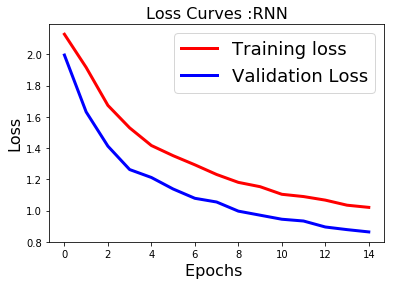

In [0]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('gdrive/My Drive/ADBI CAPSTONE PROJECT DELIVERABLES/Results/loss_RNN_1.png')
plt.show()

## Plot the  accuracy curve

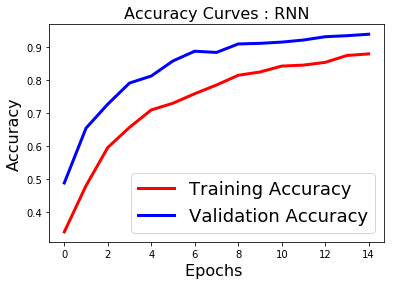

In [0]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('gdrive/My Drive/ADBI CAPSTONE PROJECT DELIVERABLES/Results/accuracy_RNN_1.png')
plt.show()

In [0]:
times = time_callback.times
times=np.round(times,2)
times

array([37.13, 17.56, 17.47, 17.46, 17.24, 17.6 , 17.57, 17.5 , 17.37,
       17.32, 17.59, 17.59, 17.59, 17.29, 17.62])

## Calculate the test accuracy

In [0]:
score = best_model.evaluate(x_test, y_test,
                       batch_size=256, verbose=1)
 
print('Test accuracy:', score[1])

2000/2000 [==============================] - 1s 522us/step
Test accuracy: 0.8529999995231629
